# Creates gif of the evolution of the training process
The plot contains two subplots
- Level sets of the predictions of the model at epoch
- Loss at epoch

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
torch.manual_seed(101)
torch.cuda.manual_seed(101)

g = torch.Generator()
g.manual_seed(1)


# Data preparation

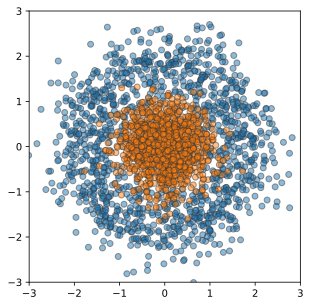

In [2]:
data_noise = 0.25
plotlim = [-3, 3]
subfolder = 'evo_circ'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('circles', noise = data_noise, plotlim = plotlim)


In [3]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[-5.0406e-01,  1.4754e-02],
        [-2.2176e+00, -2.2191e-01],
        [-2.6202e-03, -2.2924e-01],
        [-1.4166e+00, -3.8373e-01],
        [ 3.9139e-02, -3.5560e-01],
        [ 1.1496e+00,  9.3491e-01],
        [ 3.9663e-01, -9.5017e-02],
        [ 7.1716e-01,  1.1677e+00],
        [ 2.6743e+00,  9.9872e-01],
        [-7.0010e-01,  7.9120e-01]]) tensor([1, 0, 1, 1, 1, 0, 1, 1, 0, 0])


# Model dynamics

In [4]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 15, 15
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside



torch.manual_seed(2)
torch.cuda.manual_seed(2)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 


print(anode)

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
        (5): Linear(in_features=2, out_features=2, bias=True)
        (6): Linear(in_features=2, out_features=2, bias=True)
        (7): Linear(in_features=2, out_features=2, bias=True)
        (8): Linear(in_features=2, out_features=2, bias=True)
        (9): Linear(in_features=2, out_features=2, bias=True)
        (10): Linear(in_features=2, out_features=2, bias=True)
        (11): Linear(in_features=2, out_features=2, bias=True)
        (12): Linear(in_features=2, out_features=2, bias=True)
        (13): Linear(in_features=2, out_features=2, bias=True)
        (14

In [5]:
torch.manual_seed(2)
torch.cuda.manual_seed(2)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy, reduced_dynamics=True)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 


print(rnode)

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
        (5): Linear(in_features=2, out_features=2, bias=True)
        (6): Linear(in_features=2, out_features=2, bias=True)
        (7): Linear(in_features=2, out_features=2, bias=True)
        (8): Linear(in_features=2, out_features=2, bias=True)
        (9): Linear(in_features=2, out_features=2, bias=True)
        (10): Linear(in_features=2, out_features=2, bias=True)
        (11): Linear(in_features=2, out_features=2, bias=True)
        (12): Linear(in_features=2, out_features=2, bias=True)
        (13): Linear(in_features=2, out_features=2, bias=True)
        (14

# Training and generating level sets

In [6]:
from models.training import Trainer, doublebackTrainer
import imageio, os
from plots.plots import train_to_classifier_imgs

num_epochs = 120 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.
plotfreq = 10

footnote = f'{num_steps = }, {eps = }, {data_noise = }'


trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0, eps_comp = eps) 

   
train_to_classifier_imgs(anode, trainer_anode, dataloader, subfolder, num_epochs, plotfreq)


Iteration 0/38
Loss: 0.975
Robust Term Loss: 0.093
Accuracy: 0.406

Iteration 10/38
Loss: 0.773
Robust Term Loss: 0.067
Accuracy: 0.484

Iteration 20/38
Loss: 0.753
Robust Term Loss: 0.077
Accuracy: 0.469

Iteration 30/38
Loss: 0.634
Robust Term Loss: 0.054
Accuracy: 0.625
Epoch 1: 0.796

Iteration 0/38
Loss: 0.756
Robust Term Loss: 0.037
Accuracy: 0.422

Iteration 10/38
Loss: 0.684
Robust Term Loss: 0.038
Accuracy: 0.547

Iteration 20/38
Loss: 0.682
Robust Term Loss: 0.043
Accuracy: 0.547

Iteration 30/38
Loss: 0.697
Robust Term Loss: 0.044
Accuracy: 0.422
Epoch 2: 0.709

Iteration 0/38
Loss: 0.687
Robust Term Loss: 0.043
Accuracy: 0.453

Iteration 10/38
Loss: 0.728
Robust Term Loss: 0.048
Accuracy: 0.281

Iteration 20/38
Loss: 0.634
Robust Term Loss: 0.052
Accuracy: 0.453

Iteration 30/38
Loss: 0.662
Robust Term Loss: 0.060
Accuracy: 0.375
Epoch 3: 0.661

Iteration 0/38
Loss: 0.628
Robust Term Loss: 0.064
Accuracy: 0.531

Iteration 10/38
Loss: 0.602
Robust Term Loss: 0.070
Accuracy:

In [7]:
from models.training import Trainer, doublebackTrainer
import imageio, os


trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps) 



train_to_classifier_imgs(rnode, trainer_rnode, dataloader, subfolder, num_epochs, plotfreq, filename = 'rob')


Iteration 0/38
Loss: 0.936
Robust Term Loss: 0.121
Accuracy: 0.297

Iteration 10/38
Loss: 0.565
Robust Term Loss: 0.067
Accuracy: 0.625

Iteration 20/38
Loss: 0.604
Robust Term Loss: 0.048
Accuracy: 0.516

Iteration 30/38
Loss: 0.653
Robust Term Loss: 0.042
Accuracy: 0.391
Epoch 1: 0.660

Iteration 0/38
Loss: 0.610
Robust Term Loss: 0.034
Accuracy: 0.422

Iteration 10/38
Loss: 0.552
Robust Term Loss: 0.026
Accuracy: 0.547

Iteration 20/38
Loss: 0.548
Robust Term Loss: 0.024
Accuracy: 0.516

Iteration 30/38
Loss: 0.568
Robust Term Loss: 0.020
Accuracy: 0.469
Epoch 2: 0.568

Iteration 0/38
Loss: 0.541
Robust Term Loss: 0.017
Accuracy: 0.531

Iteration 10/38
Loss: 0.554
Robust Term Loss: 0.019
Accuracy: 0.500

Iteration 20/38
Loss: 0.514
Robust Term Loss: 0.018
Accuracy: 0.594

Iteration 30/38
Loss: 0.564
Robust Term Loss: 0.013
Accuracy: 0.406
Epoch 3: 0.545

Iteration 0/38
Loss: 0.569
Robust Term Loss: 0.014
Accuracy: 0.375

Iteration 10/38
Loss: 0.543
Robust Term Loss: 0.015
Accuracy:

# Loss plots

trainer_rnode.eps = 0.25
epoch = 5


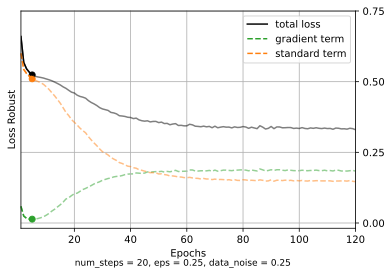

no filename given


In [8]:
from enum import auto

from plots.plots import loss_evolution
print(f'{trainer_rnode.eps = }')
loss_evolution(trainer_rnode, 5, footnote=footnote)

epoch = 20


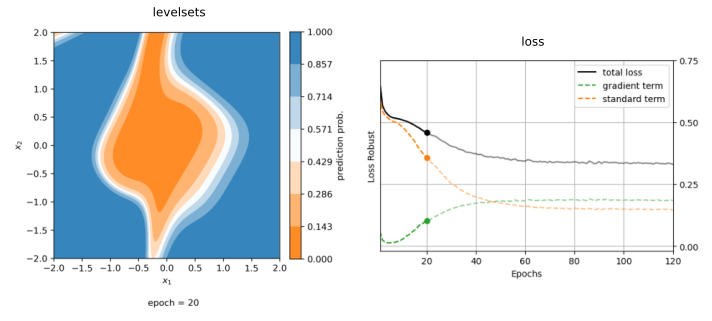

In [9]:
from plots.plots import comparison_plot

epoch = 20
fig_name_base = os.path.join(subfolder, '')
loss_evolution(trainer_rnode, epoch, 'loss_pic')
comparison_plot(fig_name_base + str(epoch) + '.png', 'levelsets', 'loss_pic.png', 'loss', 'test', show = True, figsize = (10,5))

## gif generation

In [10]:
from plots.gifs import evo_gif
gif = evo_gif(trainer_anode, num_epochs, plotfreq, subfolder, '')

10
epoch = 10
20
epoch = 20
30
epoch = 30
40
epoch = 40
50
epoch = 50
60
epoch = 60
70
epoch = 70
80
epoch = 80
90
epoch = 90
100
epoch = 100
110
epoch = 110
120
epoch = 120
evo_circ/evo.gif  created


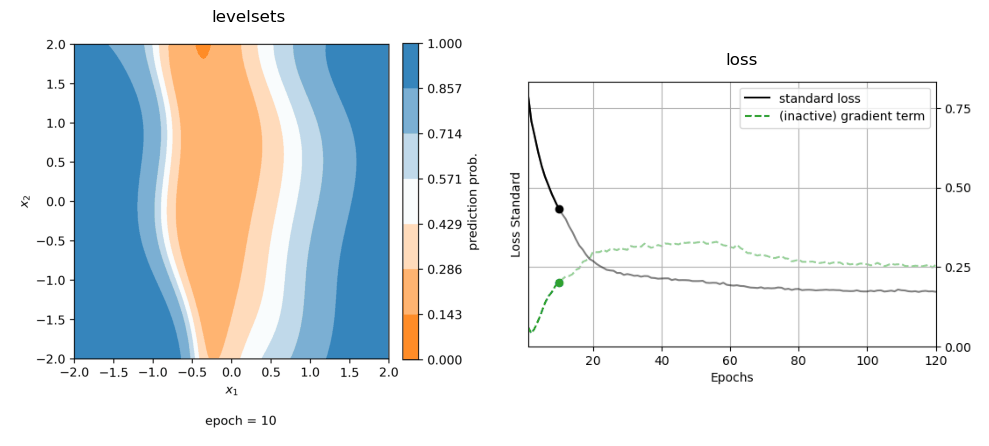

In [11]:
from IPython.display import Image
Image(filename = gif, width = 800)

10
epoch = 10
20
epoch = 20
30
epoch = 30
40
epoch = 40
50
epoch = 50
60
epoch = 60
70
epoch = 70
80
epoch = 80
90
epoch = 90
100
epoch = 100
110
epoch = 110
120
epoch = 120
evo_circ/robevo.gif  created


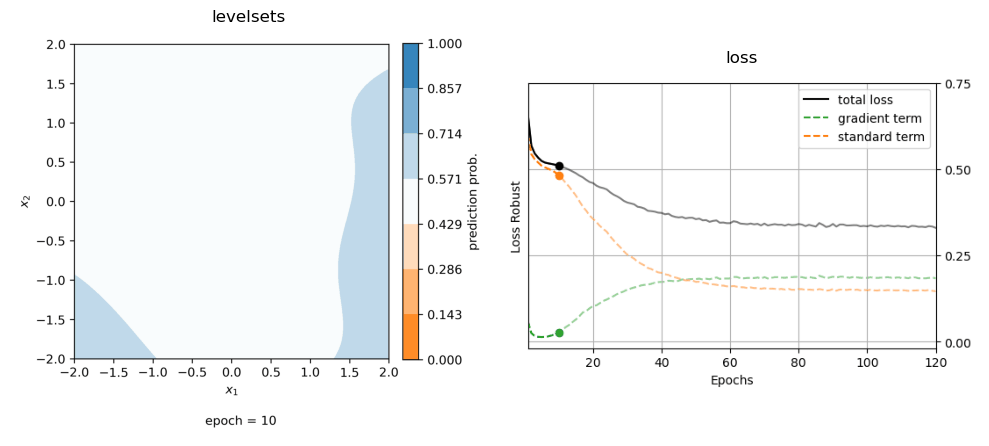

In [12]:
rob_gif = evo_gif(trainer_rnode, num_epochs, plotfreq, subfolder, 'rob')

from IPython.display import Image
Image(filename = rob_gif, width = 800)

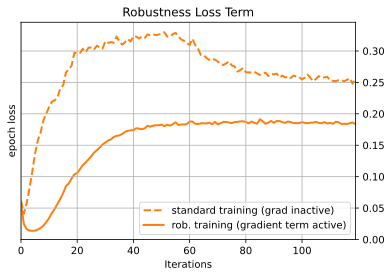

In [13]:
labelsize = 10
plt.plot(trainer_anode.histories['epoch_loss_rob_history'],'--', linewidth = 2, color = 'C1')
plt.title('Robustness Loss Term')
plt.plot(trainer_rnode.histories['epoch_loss_rob_history'], zorder = -1, linewidth = 2, color = 'C1')
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations', size = labelsize)
plt.ylabel('epoch loss', size = labelsize)
plt.legend(['standard training (grad inactive)', 'rob. training (gradient term active)'], prop= {'size': labelsize})
# plt.yticks(np.arange(0,1.25,0.25))
ax = plt.gca()
ax.yaxis.tick_right()
plt.grid()

plt.savefig('loss_comp_grads.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.show()

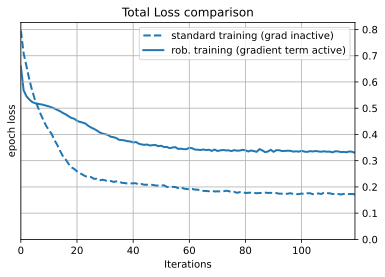

In [14]:
labelsize = 10
plt.plot(trainer_anode.histories['epoch_loss_history'],'--', linewidth = 2, color = 'C0')
plt.title('Total Loss comparison')
plt.plot(trainer_rnode.histories['epoch_loss_history'], zorder = -1, linewidth = 2, color = 'C0')
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations', size = labelsize)
plt.ylabel('epoch loss', size = labelsize)
plt.legend(['standard training (grad inactive)', 'rob. training (gradient term active)'], prop= {'size': labelsize})
# plt.yticks(np.arange(0,1.25,0.25))
ax = plt.gca()
ax.yaxis.tick_right()
plt.grid()

plt.savefig('loss_comp_grads.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.show()

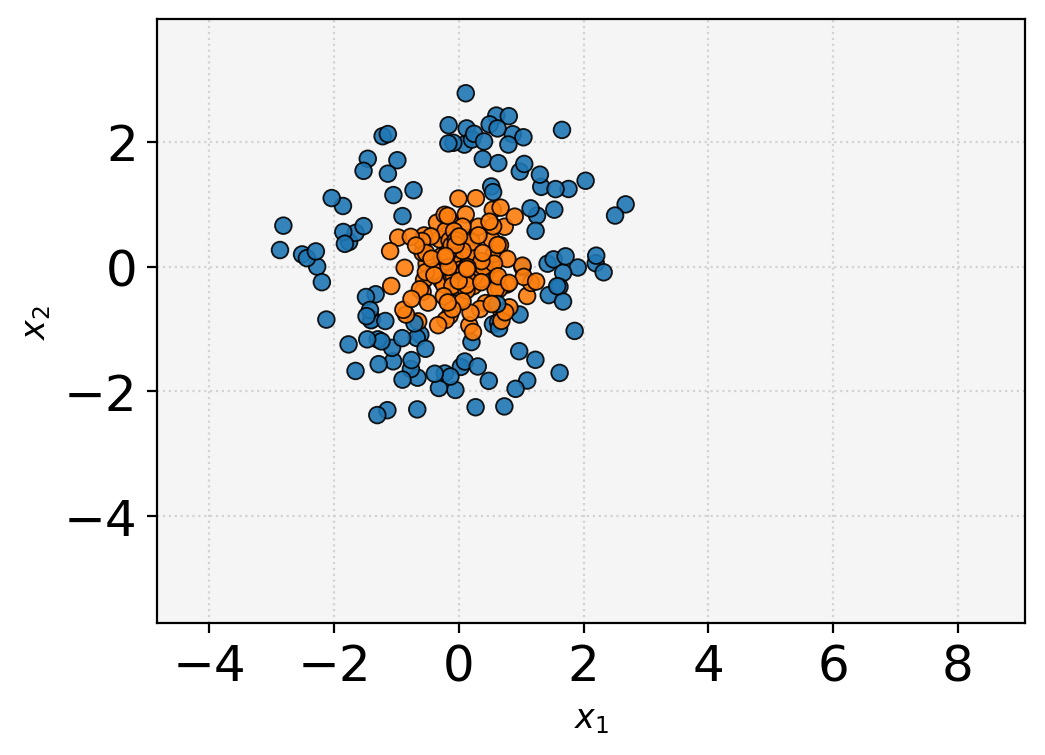

In [15]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory.gif')
    break

#Display of the generated gif

from IPython.display import Image
Image(filename="trajectory.gif", retina = True)